# Assignment 3
## 1: `git` in practice

Link to this repository: [astr8004_assign3](https://github.com/cyb0rb/astr8004_assign3)

## 2: Using ADQL to search for bright stars around the open cluster M67


In [1]:
import numpy as np
import matplotlib.colors as colors


In [ ]:
# from astroquery.gaia import Gaia

## 3: Radial metallicity relation in simulated data

In [2]:
import matplotlib.pyplot as plt
from astropy.table import Table
from scipy.optimize import curve_fit

In [3]:
# load and get data from file
datafile = "data/nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits"    
data = Table.read(datafile)
print(data.info)

# radius
radius = np.sqrt(data['x']**2 + data['y']**2 + data['z']**2)

<Table length=511520>
name  dtype 
---- -------
   x float32
   y float32
   z float32
 A_O float64



In [4]:
# fit linear function to data
def linear(x, a, b):
    return a*x + b

params, pcov = curve_fit(linear, radius, data['A_O'])
uncertainty = np.sqrt(np.diag(pcov))

print(f"Slope: {params[0]:.6f} ± {uncertainty[0]:.6f}")
print(f"Intercept: {params[1]:.5f} ± {uncertainty[1]:.5f}")

fit_data = linear(radius, *params)
residuals = data["A_O"] - fit_data

Slope: -0.033250 ± 0.000018
Intercept: 9.12232 ± 0.00028


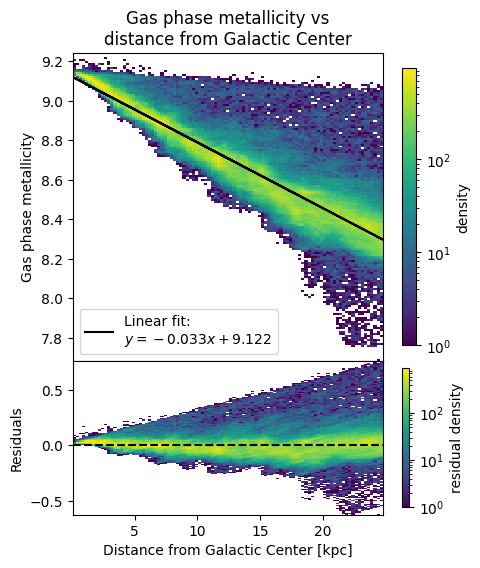

In [108]:
# plotting with a histogram instead
gridspec = {'height_ratios': [2,1]}
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw=gridspec, figsize=(5,6))
fig.subplots_adjust(hspace=0)

# radius vs metallicity
h = ax1.hist2d(radius, data['A_O'], norm=colors.LogNorm(),
    bins=(np.arange(min(radius), max(radius), 0.25), np.arange(min(data['A_O']), max(data['A_O']), 0.01)))
ax1.plot(radius, fit_data, "-k", 
    label=f"Linear fit:\n$y={params[0]:.3f}x + {params[1]:.3f}$")
plt.colorbar(h[3], ax=ax1, label="density", shrink=0.9)


# residuals
h = ax2.hist2d(radius, residuals, norm=colors.LogNorm(),
    bins=(np.arange(min(radius), max(radius), 0.25), np.arange(min(residuals), max(residuals), 0.01)))
ax2.axhline(y=0, color="black", linestyle="--")
plt.colorbar(h[3], ax=ax2, label="residual density", shrink=0.9)

# labels
ax1.set(
    ylabel = "Gas phase metallicity",
    title  = "Gas phase metallicity vs\ndistance from Galactic Center"
)
ax2.set(
    xlabel = "Distance from Galactic Center [kpc]",
    ylabel = "Residuals"
)
ax1.legend(loc="lower left")

# save

# plt.tight_layout()
fig.savefig("figures/metallicity_histogram.png")
plt.show()

### Discussion here
the linear model fits best at closer distances (<10 kpc or so), and beyond that it underestimates the metallicity.

In [50]:
from scipy.stats import binned_statistic_2d

In [98]:
# create histograms based on mean / median

# median data A_O
binstat_median, median_xedges, median_yedges, median_binnum = binned_statistic_2d(data['x'], data['y'], fit_data, statistic='median', bins=70)

# median fitted A_O
binstat_med_data, med_data_xedges, med_data_yedges, med_data_binnum = binned_statistic_2d(data['x'], data['y'], data['A_O'],  statistic='median', bins=70)

# median of A_0 residual fit
binstat_med_resids, med_resids_xedges, med_resids_yedges, med_resids_binnum = binned_statistic_2d(data['x'], data['y'], residuals, statistic='median', bins=70)

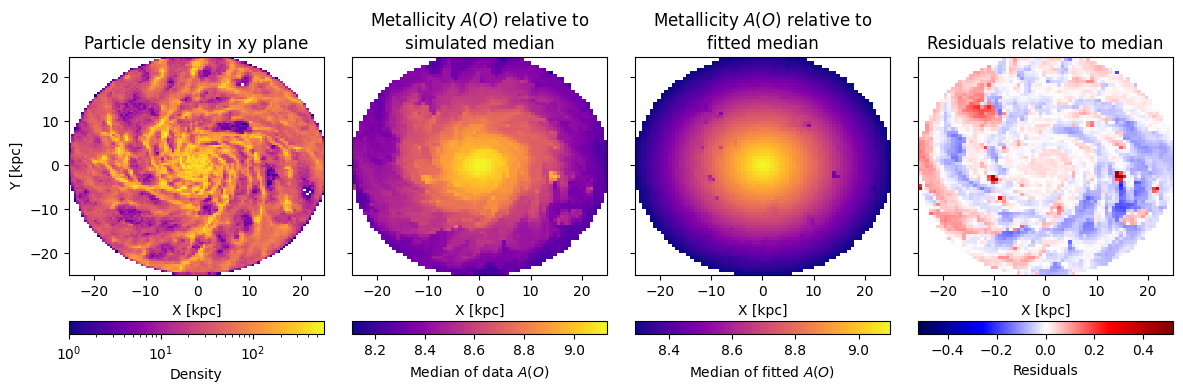

In [119]:
# plotting with a histogram instead

# gridspec = {'height_ratios': [4,1]}
fig, axs = plt.subplots(1,4, sharey=True, figsize=(12, 4))

# standard histogram
im = axs[0].hist2d(data['x'], data['y'], 
                   bins=(np.arange(min(data['x']), max(data['x']), 0.5), np.arange(min(data['y']), max(data['y']), 0.5)),
                   norm=colors.LogNorm(), cmap='plasma')
axs[0].set(xlabel = "X [kpc]", ylabel = "Y [kpc]", title="Particle density in xy plane")
plt.colorbar(im[3], ax=axs[0], label="Density", orientation='horizontal')

# median from the data
im = axs[1].imshow(binstat_med_data.T, origin='lower', aspect='auto',
                   extent=[med_data_xedges[0], med_data_xedges[-1], med_data_yedges[0], med_data_yedges[-1]],
                   cmap='plasma')
axs[1].set(title="Metallicity $A(O)$ relative to\nsimulated median", xlabel="X [kpc]")
plt.colorbar(im, ax=axs[1], label="Median of data $A(O)$", orientation='horizontal')

# median from fit
im = axs[2].imshow(binstat_median.T, origin='lower', aspect='auto',
                   extent=[median_xedges[0], median_xedges[-1], median_yedges[0], median_yedges[-1]],
                   cmap='plasma')
axs[2].set(title="Metallicity $A(O)$ relative to\nfitted median", xlabel="X [kpc]")
plt.colorbar(im, ax=axs[2], label="Median of fitted $A(O)$", orientation='horizontal')

# residual median
im = axs[3].imshow(binstat_med_resids.T, origin='lower', aspect='auto',
                   extent=[med_resids_xedges[0], med_resids_xedges[-1], med_resids_yedges[0], med_resids_yedges[-1]],
                   cmap='seismic', norm=colors.CenteredNorm())
axs[3].set(title="Residuals relative to median", xlabel="X [kpc]")
plt.colorbar(im, ax=axs[3], label="Residuals", orientation='horizontal')

# save
fig.tight_layout()
fig.savefig("figures/metallicity_xy.png")
plt.show()